In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
os.chdir("../")

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import torch

from graph_utils import GraphData, load_graph, verify_graph, degrees, grid_extent

# Overlay Mesh Graph on UK Map

In [3]:
proj = ccrs.PlateCarree()

In [4]:
def add_geo_features(ax):
    ax.add_feature(cfeature.BORDERS, linestyle=':')
      
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
def add_cities(ax, cities):
    for city, (lon, lat) in cities.items():
        ax.plot(lon, lat, 'ro', transform=proj)
        ax.text(lon + 0.1, lat + 0.1, city, transform=proj)
        
def bounding_box(ax, box):
    lon_min, lon_max, lat_min, lat_max = box
    top_left = [lon_min, lat_max]
    top_right = [lon_max, lat_max]
    bottom_left = [lon_min, lat_min]
    bottom_right = [lon_max, lat_min]
    
    corners = [
        bottom_left,
        top_left,
        top_right,
        bottom_right,
        bottom_left,
    ]
    
    lons, lats = zip(*corners)
    
    ax.plot(
        lons, lats,
        "r-", 
        transform=proj
    )
    
def grid_points(ax, grid_xy, color="green", markersize=1):
    ax.plot(grid_xy[0], grid_xy[1], 'o', color=color, transform=proj, markersize=markersize)

def mesh_points(ax, mesh_pos, mesh_node_levels=None, filter_level=None, color="g"):
    color_map = {
        0: 'blue',
        1: 'green',
        2: 'orange',
        3: 'cyan',
        4: 'magenta',
        5: 'yellow',
        6: 'black'
    }
    if mesh_node_levels:
        for i in range(len(mesh_pos[0])):
            if filter_level and mesh_node_levels[i] != filter_level:
                continue
            node_color = color_map[mesh_node_levels[i]]
            ax.plot(mesh_pos[0][i], mesh_pos[1][i], 'o', color=node_color, transform=proj, markersize=3)
    else:
        ax.plot(mesh_pos[0], mesh_pos[1], 'o', color=color, transform=proj, markersize=3)

def m2m_edges(ax, mesh_pos, m2m_edge_set):        
    for edge in m2m_edge_set:
        source = mesh_pos[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "g-", 
            transform=proj,
            linewidth=0.5
        )
        
def coarse2fine_edges(ax, coarse_pos, fine_pos, coarse2fine_edge_set):
    for edge in coarse2fine_edge_set:
        source = coarse_pos[:, edge[0]]
        target = fine_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "g-", 
            transform=proj,
            linewidth=0.5
        )
        
def g2m_edges(ax, grid_xy, mesh_pos, g2m_edge_set, mesh_node_levels=None, filter_mesh_level=None): 
    for edge in g2m_edge_set:
        if mesh_node_levels and filter_mesh_level and mesh_node_levels[edge[1]] != filter_mesh_level:
            continue
        source = grid_xy[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "b-", 
            transform=proj,
            linewidth=0.5
        )

def m2g_edges(ax, grid_xy, mesh_pos, m2g_edge_set):        
    for edge in m2g_edge_set:
        source = mesh_pos[:, edge[0]]
        target = grid_xy[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "r-", 
            transform=proj,
            linewidth=0.5
        )

## Load datas

In [5]:
dataset = "era5_uk_small"
graph_name = "uk_small_ico"

# dataset = "era5_uk"
# graph_name = "uk_ico"

# dataset = "era5_uk_big"
# graph_name = "uk_big_ico"

dataset_coarse = "era5_uk_big_coarse"
coarse_graph_name = "uk_big_coarse_ico"

In [6]:
graph = load_graph(dataset, graph_name)
coarse_graph = load_graph(dataset_coarse, coarse_graph_name)
# full_coarse_graph = load_graph(dataset_coarse, f"{coarse_graph_name}_full")

(2, 46, 40)
(2, 27, 27)


In [7]:
verify_graph(graph)

Verify g2m connectivity
Grid Nodes min, max:  tensor(0) tensor(1839)
Mesh nodes min, max:  tensor(0) tensor(78)
Grid Nodes unique: 1840
Mesh nodes unique: 79
Verify m2g connectivity
Grid Nodes min, max:  tensor(0) tensor(78)
Mesh nodes min, max:  tensor(0) tensor(1839)
Grid Nodes unique: 79
Mesh nodes unique: 1840
Grid Bounding box:
[-8.0, 1.75, 49.75, 61.0]


## Fine 2 Coarse graph edges

In [8]:
coarse2fine_edge_index = torch.load(f"./graphs/{graph_name}/coarse2fine_edge_index.pt")
coarse2fine_edge_set = sorted(list({tuple(e) for e in coarse2fine_edge_index.T}))

# Plot Map

UK Settlements Bounding box:
[-8.0, 1.75, 49.75, 61.0]


Text(0.5, 1.0, 'ERA5 UK - GraphCast')

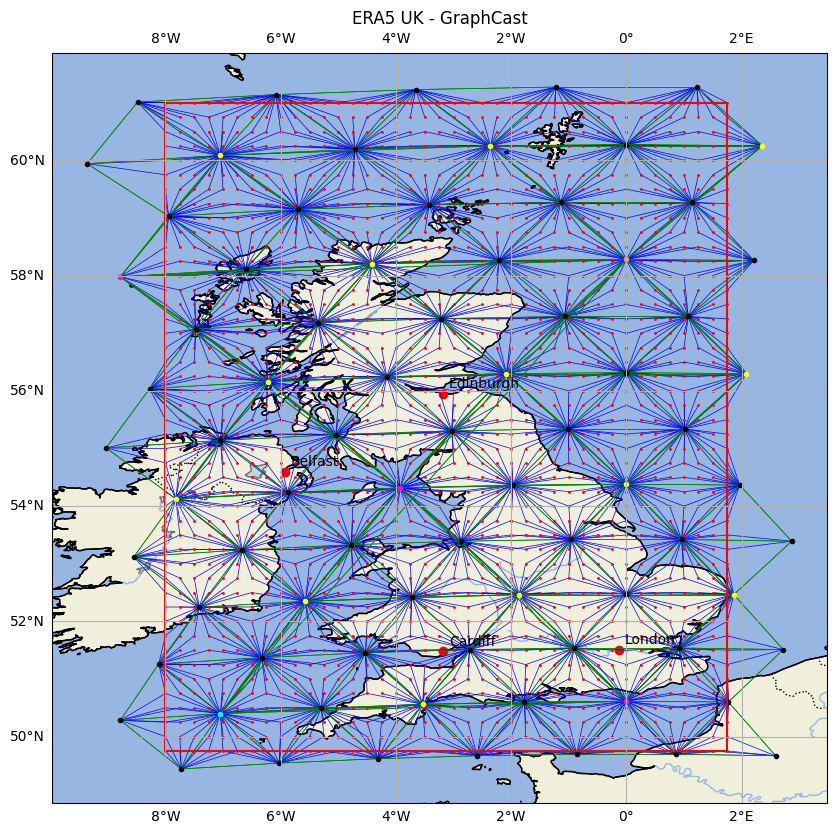

In [9]:
# Create a map with PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})

# Add geographical features
add_geo_features(ax)

# Add cities
cities = {
    'London': (-0.1276, 51.5074),
    'Edinburgh': (-3.1883, 55.9533),
    'Cardiff': (-3.1791, 51.4816),
    'Belfast': (-5.9301, 54.5973)
}
add_cities(ax, cities)

g2m_edges(ax, graph.grid_xy, graph.mesh_pos, graph.g2m_edge_set)
m2m_edges(ax, graph.mesh_pos, graph.m2m_edge_set)
# m2g_edges(ax, graph.grid_xy, graph.mesh_pos, graph.m2g_edge_set)
grid_points(ax, graph.grid_xy, "red")
mesh_points(ax, graph.mesh_pos, graph.mesh_node_levels)

# m2m_edges(ax, graph.mesh_pos, graph.m2m_edge_set)
# grid_points(ax, graph.grid_xy, "red")
# mesh_points(ax, graph.mesh_pos, graph.mesh_node_levels)

# m2m_edges(ax, coarse_graph.mesh_pos, coarse_graph.m2m_edge_set)
# grid_points(ax, coarse_graph.grid_xy, "red")
# mesh_points(ax, coarse_graph.mesh_pos, coarse_graph.mesh_node_levels)

# coarse2fine_edges(ax, coarse_graph.mesh_pos, graph.mesh_pos, coarse2fine_edge_set)
# # m2m_edges(ax, full_coarse_graph.mesh_pos, full_coarse_graph.m2m_edge_set)
# grid_points(ax, coarse_graph.grid_xy, "red")
# mesh_points(ax, coarse_graph.mesh_pos, coarse_graph.mesh_node_levels)
# # mesh_points(ax, graph.mesh_pos, graph.mesh_node_levels)
# mesh_points(ax, graph.mesh_pos)

uk_settlments = [-8.00, 1.75, 49.75, 61.00]
print("UK Settlements Bounding box:")
print(uk_settlments)
bounding_box(ax, uk_settlments)

# Add gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_lables = False
gl.right_labels = False

plt.title('ERA5 UK - GraphCast')

In [10]:
len(coarse2fine_edge_index[1].unique())

79

In [11]:
coarse2fine_edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  4,  4,  4,  4,  4,  4,  4,  4,
          6,  7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 13, 13, 14, 14, 14, 14, 14, 14, 16, 16, 19, 19,
         19, 19, 19, 19, 20, 21, 21, 21, 21, 23, 27, 27, 29, 29, 31, 31, 31, 31,
         31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
         32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 35, 35, 35, 35, 35,
         36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38,
         38, 38, 39, 39, 39, 39, 39, 39, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46,
         46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48,
         48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50,
         55, 55, 55, 55, 56,

In [17]:
# import networkx as nx
import dgl

/vol/bitbucket/bet20/nlam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
data_dict = {
    ("mesh", "m2m", "mesh"): (m2m_edge_index[0], m2m_edge_index[1]),
    ("grid", "g2m", "mesh"): (g2m_edge_index[0], g2m_edge_index[1]),
}

N_mesh = mesh_pos.shape[1]
N_grid = grid_xy.shape[1]
num_nodes_dict = {"mesh": N_mesh, "grid": N_grid}

G = dgl.heterograph(data_dict, num_nodes_dict)
G.nodes["mesh"].data["pos"] = mesh_pos.T
G.nodes["grid"].data["pos"] = grid_xy.T

AttributeError: 'numpy.ndarray' object has no attribute 'device'

In [ ]:
# small_uk = [-14.015517, 2.0919117, 49.674, 61.061]
# small_uk = [-13.0, 7.0, 45.0, 65.0]
# print("UK Bounding box:")
# print(small_uk)
# print(small_uk[1] - small_uk[0], small_uk[3] - small_uk[2])
# bounding_box(ax, small_uk)